# W207 Facial Keynotes

#Team 

Members:
- Tucker Anderson
- Bruno Todescan
- Madia Taher

# EDA

duplicate
check preprocessing
pair dropping
how can we check outliers? 



In [0]:
#import libraries
from tensorflow import keras as keras
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline



In [10]:
lookid_data = pd.read_csv("IdLookupTable.csv")
lookid_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
samplesubmission = pd.read_csv("SampleSubmission.csv")
samplesubmission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [18]:
train_data = pd.read_csv("training.csv")
train_data.head().T


,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [17]:
train_data['Image']

0      238 236 237 238 240 240 239 241 241 243 240 23...
1      219 215 204 196 204 211 212 200 180 168 178 19...
2      144 142 159 180 188 188 184 180 167 132 84 59 ...
3      193 192 193 194 194 194 193 192 168 111 50 12 ...
4      147 148 160 196 215 214 216 217 219 220 206 18...
5      167 169 170 167 156 145 106 68 52 24 20 15 21 ...
6      109 109 125 141 145 139 120 81 45 34 31 35 36 ...
7      178 177 178 179 179 179 181 185 188 184 192 20...
8      164 158 118 76 66 69 59 53 43 31 35 41 45 55 6...
9      226 227 225 224 221 220 215 210 210 208 206 18...
10     52 51 54 57 57 56 55 55 56 59 62 66 67 72 79 8...
11     142 124 123 133 140 147 151 147 137 136 125 12...
12     86 93 106 114 112 110 111 113 138 147 148 132 ...
13     75 65 63 75 70 78 84 97 106 71 39 25 23 21 18 ...
14     119 106 101 106 89 66 67 72 85 112 118 109 96 ...
15     52 54 74 76 55 48 47 41 38 37 34 33 33 31 30 3...
16     201 200 202 193 124 59 53 50 48 56 66 76 114 1...
17     202 201 201 202 201 200 

In [20]:
test_data = pd.read_csv("test.csv")
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [0]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [0]:
print(train_data.count())# prints the number of values for each column
print(len(train_data))
df = train_data.dropna()  # drop all rows that have missing values in them
len(df)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

2140

In [0]:
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

In [0]:
def load_dataset():

    Xtrain = []
    Ytrain = []
    with open('training.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            Yitem = []
            failed = False
            for coord in row:
                if coord == "Image":
                    continue
                if(row[coord].strip()==""):
                    failed = True
                    break
                Yitem.append(float(row[coord]))
            if not failed:
                Xtrain.append(img)
                Ytrain.append(Yitem)
                
    return np.array(Xtrain), np.array(Ytrain, dtype=np.float)

In [47]:
Xdata, Ydata = load_dataset()
Xtrain = Xdata[:]
Ytrain = Ydata[:]
Xtrain[10]

array([[[ 52.],
        [ 51.],
        [ 54.],
        ...,
        [208.],
        [209.],
        [211.]],

       [[ 57.],
        [ 61.],
        [ 60.],
        ...,
        [210.],
        [212.],
        [212.]],

       [[ 58.],
        [ 59.],
        [ 58.],
        ...,
        [214.],
        [210.],
        [211.]],

       ...,

       [[ 89.],
        [ 80.],
        [ 82.],
        ...,
        [191.],
        [191.],
        [188.]],

       [[ 82.],
        [ 78.],
        [ 79.],
        ...,
        [191.],
        [190.],
        [190.]],

       [[ 76.],
        [ 70.],
        [ 72.],
        ...,
        [193.],
        [190.],
        [187.]]])

In [0]:
def show_image(X, Y):
    img = np.copy(X)
    for i in range(0,Y.shape[0],2):
        if 0 < Y[i+1] < IMAGE_HEIGHT and 0 < Y[i] < IMAGE_WIDTH:
            img[int(Y[i+1]),int(Y[i]),0] = 255
    plt.imshow(img[:,:,0])

In [30]:
show_image(Xtrain[2], Ytrain[2])

IndexError: ignored

In [0]:
# Configure Model
model = keras.Sequential([keras.layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,1)),
                         keras.layers.Dense(128, activation="relu"),
                         keras.layers.Dropout(0.1),
                         keras.layers.Dense(64, activation="relu"),
                         keras.layers.Dense(30)
                         ])

W0711 21:51:49.518418 140465571891072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Compile model
model.compile(optimizer=tf.train.AdamOptimizer, 
              loss='mse',
              metrics=['accuracy'])

In [0]:
# Train model
model.fit(Xtrain, Ytrain, epochs=50)

Epoch 1/50
2140/2140 [==============================] - 1s 404us/sample - loss: 13.8178 - acc: 0.7033
Epoch 2/50
2140/2140 [==============================] - 1s 371us/sample - loss: 10.1687 - acc: 0.7051
Epoch 3/50
2140/2140 [==============================] - 1s 366us/sample - loss: 10.1623 - acc: 0.7051
Epoch 4/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1621 - acc: 0.7051
Epoch 5/50
2140/2140 [==============================] - 1s 365us/sample - loss: 10.1630 - acc: 0.7051
Epoch 6/50
2140/2140 [==============================] - 1s 368us/sample - loss: 10.1545 - acc: 0.7051
Epoch 7/50
2140/2140 [==============================] - 1s 366us/sample - loss: 10.1651 - acc: 0.7051
Epoch 8/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1616 - acc: 0.7051
Epoch 9/50
2140/2140 [==============================] - 1s 367us/sample - loss: 10.1598 - acc: 0.7051
Epoch 10/50
2140/2140 [==============================] - 1s 373us/sample - loss: 1

In [0]:
# Load test data
def load_testset():
    Xtest = []
    with open('test.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1), dtype=np.float)
            for i, val in enumerate(row["Image"].split(" ")):
                img[i//IMAGE_WIDTH,i%IMAGE_WIDTH,0] = val
            Xtest.append(img)
                
    return np.array(Xtest)
Xtest = load_testset()

In [0]:
def show_results(image_index):
    Ypred = model.predict(Xtest[image_index:(image_index+1)])
    show_image(Xtest[image_index], Ypred[0])

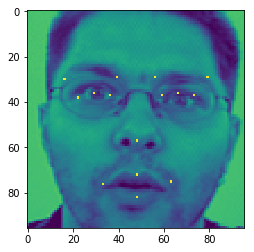

In [0]:
show_results(10)

In [48]:
show_results(6220)

NameError: ignored